1.Gather the dataset of hubNashville requests from https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh. For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". Explore this dataset, looking at when and where these violations occurred. 

In [1]:
import numpy as np
import requests
import ipywidgets as widgets
from IPython.core.display import HTML
import matplotlib as mpl
import pylab as plt
import json
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
#from cartopy.io import shapereader


In [2]:
#https://data.nashville.gov/resource/7qhx-rexh.geojson

In [3]:
nville_311 = pd.read_csv('../data/hubNashville__311__Service_Requests.csv')
nville_311.head(3)

C:\Users\daily\anaconda3\envs\geospatial\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Request #,Status,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Date / Time Closed,Request Origin,System of Origin ID,Contact Type,...,State Issue,Parent Request,Closed When Created,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
0,113016,Closed,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,03/05/2019 09:35:00 PM,Phone,NaN,NaN,...,False,NaN,False,2009 Upland Dr,NASHVILLE,7.0,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,53502,Closed,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,04/06/2018 01:13:32 PM,Phone,NaN,NaN,...,False,NaN,False,631 Murfreesboro Pike,NASHVILLE,17.0,37210,36.140070,-86.738360,"(36.14007, -86.73836)"
2,119344,Closed,"Trash, Recycling & Litter",Damage to Property,Trash Service,11/27/2018 02:20:00 PM,11/29/2018 04:04:00 AM,Phone,NaN,NaN,...,False,NaN,True,"597 Westchester Dr, Nashville, TN 37115, Unite...",MADISON,8.0,37115,36.263020,-86.738630,"(36.26302, -86.73863)"


In [4]:
covid_311 = nville_311.drop(['Request Origin', 'System of Origin ID',
       'Contact Type', 'Preferred Language', 'State Issue', 'Parent Request',
       'Closed When Created', 'Status', 'Date / Time Closed'], axis = 1)
covid_311.head(3)

,Request #,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
0,113016,"Trash, Recycling & Litter",Cart Service,Trash - Request an Additional Cart,10/30/2018 01:47:00 PM,2009 Upland Dr,NASHVILLE,7.0,37216,36.198638,-86.706659,"(36.1986378, -86.7066586)"
1,53502,Property Violations,Residential Complaint,Residential Complaint,03/13/2018 09:34:50 PM,631 Murfreesboro Pike,NASHVILLE,17.0,37210,36.140070,-86.738360,"(36.14007, -86.73836)"
2,119344,"Trash, Recycling & Litter",Damage to Property,Trash Service,11/27/2018 02:20:00 PM,"597 Westchester Dr, Nashville, TN 37115, Unite...",MADISON,8.0,37115,36.263020,-86.738630,"(36.26302, -86.73863)"


In [5]:
covid_311_rt = covid_311.loc[covid_311['Request Type'].isin(['COVID-19'])]

In [6]:
covid_311_srt = covid_311_rt.loc[covid_311_rt['Subrequest Type'].isin(['COVID-19 Violations'])]
covid_311_srt.head(3)

,Request #,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
1547,444823,COVID-19,COVID-19 Violations,COVID-19 Violations,08/14/2020 02:38:00 AM,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)"
3379,479965,COVID-19,COVID-19 Violations,COVID-19 Violations,10/13/2020 11:48:40 AM,2800 Opryland Dr,NASHVILLE,15.0,37214,36.211269,-86.694302,"(36.211269429469425, -86.6943024067459)"
3660,392927,COVID-19,COVID-19 Violations,COVID-19 Violations,06/16/2020 12:35:20 AM,2607 12th Ave S,NASHVILLE,18.0,37204,36.123500,-86.790130,"(36.1235, -86.79013)"


In [7]:
covid_311_srt.drop(columns = ['Additional Subrequest Type'], axis = 1)
covid_311_srt.head(3)

,Request #,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
1547,444823,COVID-19,COVID-19 Violations,COVID-19 Violations,08/14/2020 02:38:00 AM,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)"
3379,479965,COVID-19,COVID-19 Violations,COVID-19 Violations,10/13/2020 11:48:40 AM,2800 Opryland Dr,NASHVILLE,15.0,37214,36.211269,-86.694302,"(36.211269429469425, -86.6943024067459)"
3660,392927,COVID-19,COVID-19 Violations,COVID-19 Violations,06/16/2020 12:35:20 AM,2607 12th Ave S,NASHVILLE,18.0,37204,36.123500,-86.790130,"(36.1235, -86.79013)"


In [38]:
covid_311_srt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11632 entries, 1547 to 479249
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Request #                   11632 non-null  int64         
 1   Request Type                11632 non-null  object        
 2   Subrequest Type             11632 non-null  object        
 3   Additional Subrequest Type  11623 non-null  object        
 4   Date_opened                 11632 non-null  datetime64[ns]
 5   Address                     11258 non-null  object        
 6   City                        10653 non-null  object        
 7   Council District            10686 non-null  float64       
 8   ZIP                         10718 non-null  object        
 9   Latitude                    11354 non-null  float64       
 10  Longitude                   11354 non-null  float64       
 11  Mapped Location             11354 non-null  object

In [8]:
covid_311_srt['Address'].nunique()

4829

In [9]:
covid_311_srt['City'].unique()

array(['ANTIOCH', 'NASHVILLE', 'Nashville', 'MADISON', nan, 'HERMITAGE',
       'GOODLETTSVILLE', 'BRENTWOOD', 'JOELTON', 'OLD HICKORY',
       'WHITES CREEK', 'LAVERGNE', 'NOLENSVILLE', 'LA VERGNE'],
      dtype=object)

In [10]:
covid_311_srt = covid_311_srt.rename(columns = {"Date / Time Opened":"Date_opened"})
covid_311_srt.head(3)

,Request #,Request Type,Subrequest Type,Additional Subrequest Type,Date_opened,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location
1547,444823,COVID-19,COVID-19 Violations,COVID-19 Violations,08/14/2020 02:38:00 AM,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)"
3379,479965,COVID-19,COVID-19 Violations,COVID-19 Violations,10/13/2020 11:48:40 AM,2800 Opryland Dr,NASHVILLE,15.0,37214,36.211269,-86.694302,"(36.211269429469425, -86.6943024067459)"
3660,392927,COVID-19,COVID-19 Violations,COVID-19 Violations,06/16/2020 12:35:20 AM,2607 12th Ave S,NASHVILLE,18.0,37204,36.123500,-86.790130,"(36.1235, -86.79013)"


In [11]:
covid_311_srt['Date_opened'] = pd.to_datetime(covid_311_srt['Date_opened'], errors='coerce')
covid_311_srt['Complaint_date'] = covid_311_srt['Date_opened'].dt.strftime('%Y-%m-%d')
covid_311_srt['Complaint_time'] = covid_311_srt['Date_opened'].dt.strftime('%H:%M')
#df['Date'] = df['DateTime'].dt.strftime('%d/%m/%Y')
#df['Time'] = df['DateTime'].dt.strftime('%H:%M')

In [12]:
# I decided just to remove the Date Closed column
#covid_311_srt['Date_closed'] = pd.to_datetime(covid_311_srt['Date_closed'], errors='coerce')

In [13]:
covid_311_srt['City'].describe()

count         10653
unique           13
top       NASHVILLE
freq           8627
Name: City, dtype: object

11,632 entries but there are only 10,653 Cities? Missing almost 1,000 cities..  

In [14]:
#covid_date = covid_311_srt.groupby('Request Type')['Council District'].hist();

<AxesSubplot:>

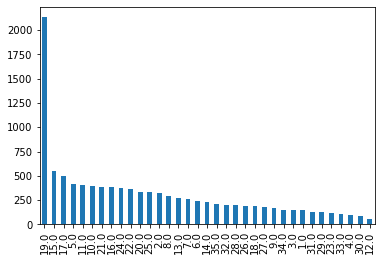

In [15]:
#look at volume by Council District
covid_311_srt['Council District'].value_counts().plot(kind = 'bar')

Council District 19 is southeast of downtown Nville
Council District 15 is east of District 19 (perhaps East Nashville)
Council District 17 includes Wedgewood Houston/Fairgrounds

https://www.nashville.gov/Planning-Department/Mapping-and-GIS/Interactive-Maps.aspx

In [16]:
# created histogram of volume by date, but does not show much  
# plt.figure(figsize=(15,8))
# covid_311_srt['Complaint_date'].hist(bins = 25);

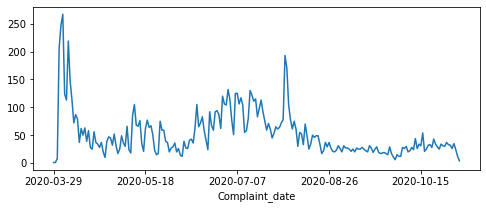

In [17]:
complaint_dates = covid_311_srt.groupby('Complaint_date')['Request Type'].count().plot(figsize=(8,3))

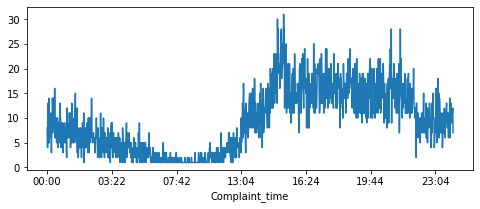

In [18]:
complaint_times = covid_311_srt.groupby('Complaint_time')['Request Type'].count().plot(figsize=(8,3))

In [19]:
covid_311_srt['geometry'] = covid_311_srt.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)
covid_311_srt.head(3)

,Request #,Request Type,Subrequest Type,Additional Subrequest Type,Date_opened,Address,City,Council District,ZIP,Latitude,Longitude,Mapped Location,Complaint_date,Complaint_time,geometry
1547,444823,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",2020-08-14,02:38,POINT (-86.6838975 36.06854570000001)
3379,479965,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-13 11:48:40,2800 Opryland Dr,NASHVILLE,15.0,37214,36.211269,-86.694302,"(36.211269429469425, -86.6943024067459)",2020-10-13,11:48,POINT (-86.6943024067459 36.21126942946943)
3660,392927,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-16 00:35:20,2607 12th Ave S,NASHVILLE,18.0,37204,36.123500,-86.790130,"(36.1235, -86.79013)",2020-06-16,00:35,POINT (-86.79013 36.1235)


In [20]:
#bring in Nashville Hub cluster data 
covid_cluster = pd.read_csv('../data/clusters.csv')
covid_cluster.head(3)

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.125891,-86.822863
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.8467716
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN


In [21]:
covid_cluster['Cluster Start Date'] = pd.to_datetime(covid_cluster['Cluster Start Date'], errors='coerce')
covid_cluster['Cluster_date'] = covid_cluster['Cluster Start Date'].dt.strftime('%Y-%m-%d')
covid_cluster['Cluster_date'] = pd.to_datetime(covid_cluster['Cluster_date'], errors='coerce')

# covid_311_srt['Date_opened'] = pd.to_datetime(covid_311_srt['Date_opened'], errors='coerce')
# covid_311_srt['Complaint_date'] = covid_311_srt['Date_opened'].dt.strftime('%Y-%m-%d')

In [22]:
covid_cluster.head(3)

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude,Cluster_date
0,Vanderbilt Parties,Social Gathering,2020-03-11,49,36.125891,-86.822863,2020-03-11
1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.8467716,2020-03-14
2,Religious Retreat,Social Gathering,2020-03-25,18,NaN,NaN,2020-03-25


In [23]:
covid_cluster.drop(columns=['Cluster Start Date'], axis=1)

,Cluster Name,Facility Type,# Cases,Latitude,Longitude,Cluster_date
0,Vanderbilt Parties,Social Gathering,49,36.125891,-86.822863,2020-03-11
1,Event at Clementine Hall,Social Gathering,23,36.152444,-86.8467716,2020-03-14
2,Religious Retreat,Social Gathering,18,NaN,NaN,2020-03-25
3,The Health Center at Richland Place,LTCF,47,36.128750,-86.8195333,2020-04-03
4,Trevecca Center for Rehab and Healing,LTCF,102,36.144562,-86.7567485,2020-04-04
...,...,...,...,...,...,...
57,One Stone Church Service,Church,10,36.189960,-86.7673379,2020-09-22
58,Miss Kelli's,Bar,14,36.164369,-86.7807037,2020-10-01
59,Nashville Rescue Mission - Women's Campus,Congregate Living,70,36.167693,-86.7957557,2020-10-01
60,Link Systems Electric,Other,12,36.092924,-86.7438727,2020-10-16


In [37]:
covid_cluster['geometry'] = covid_cluster.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)
covid_cluster.head(3)

ValueError: could not convert string to float: ',-86.7779142'

In [24]:
covid_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Cluster Name        62 non-null     object        
 1   Facility Type       62 non-null     object        
 2   Cluster Start Date  62 non-null     datetime64[ns]
 3   # Cases             62 non-null     int64         
 4   Latitude            52 non-null     float64       
 5   Longitude           52 non-null     object        
 6   Cluster_date        62 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 3.5+ KB


In [25]:
#read in # of cases file 
covid_cases = pd.read_csv('../data/davidson_cases.csv')
covid_cases.head(50)

,date,county,state,fips,cases,deaths
0,2020-03-08,Davidson,Tennessee,47037,1,0
1,2020-03-09,Davidson,Tennessee,47037,1,0
2,2020-03-10,Davidson,Tennessee,47037,1,0
3,2020-03-11,Davidson,Tennessee,47037,2,0
4,2020-03-12,Davidson,Tennessee,47037,6,0
5,2020-03-13,Davidson,Tennessee,47037,10,0
6,2020-03-14,Davidson,Tennessee,47037,14,0
7,2020-03-15,Davidson,Tennessee,47037,17,0
8,2020-03-16,Davidson,Tennessee,47037,25,0
9,2020-03-17,Davidson,Tennessee,47037,42,0


In [34]:
covid_cases['Case_date'] = pd.to_datetime(covid_cases['date'], errors='coerce')

# covid_311_srt['Date_opened'] = pd.to_datetime(covid_311_srt['Date_opened'], errors='coerce')
# covid_311_srt['Complaint_date'] = covid_311_srt['Date_opened'].dt.strftime('%Y-%m-%d')

In [35]:
covid_cases.drop(columns=['date', 'state', 'county', 'fips'], axis=1)

,cases,deaths,Case_date
0,1,0,2020-03-08
1,1,0,2020-03-09
2,1,0,2020-03-10
3,2,0,2020-03-11
4,6,0,2020-03-12
...,...,...,...
230,33016,336,2020-10-24
231,33259,337,2020-10-25
232,33699,343,2020-10-26
233,33957,341,2020-10-27


In [36]:
covid_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       235 non-null    object        
 1   county     235 non-null    object        
 2   state      235 non-null    object        
 3   fips       235 non-null    int64         
 4   cases      235 non-null    int64         
 5   deaths     235 non-null    int64         
 6   Case_date  235 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.0+ KB


My goal is to combine the violation data with the cluster data on lat/long or geometry.  Then bring in the cases.  Run line plots showing each occurence by dates (complaint_date, cluster_date, case_date) and the volume of each.  Overlay on map using geometry.  

In [ ]:
# merge (or join?) violation data with cluster data on lat/long or geometry.  Then join in cases
covid_viol_cluster = covid_311_srt.merge

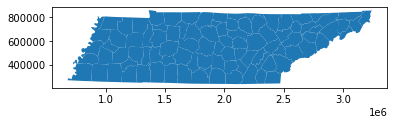

In [28]:
# Read in TN County Map
tn_county_map = gpd.read_file('../data/tncounty.shp')
tn_county_map.plot();

In [29]:
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [30]:
#narrow tn county map to just Davidson for overlay
david_county_map = tn_county_map[tn_county_map['NAME'].isin(['Davidson'])]
david_county_map.head(3)

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
20,25,Davidson,47037,1.465730e+10,679930.031216,"POLYGON ((1699730.035 747536.751, 1699790.248 ..."


In [31]:
# change the projection type
david_county_map = david_county_map.to_crs('EPSG:4326')
print(david_county_map.crs)
# Clean up some of the columns we don't need
david_county_map = david_county_map.drop(['OBJECTID', 'KEY', 'SHAPE_LEN'], axis = 1)
# Reformat column headers
david_county_map.columns = ['county', 'shape_area', 'geometry']
# Set the county names to lower case
#david_county_map['county'] = david_county_map['county'].str.lower()
# Make sure the base map dataset is good to go
david_county_map.head(2)

EPSG:4326


,county,shape_area,geometry
20,Davidson,1.465730e+10,"POLYGON ((-86.91304 36.38349, -86.91284 36.383..."


In [32]:
david_county_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
#merge Hub Nashville 311 violations with Davidson county map
david_county_viol = david_county_map.merge(covid_311_srt, on = 'geometry')
david_county_viol.head()

TypeError: unhashable type: 'Polygon'

In [ ]:
#tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')